In [1]:
device = 'cuda'

In [2]:
import warnings
warnings.filterwarnings("ignore")

try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PREFIX = '/content/drive/MyDrive/m1p'

    IN_COLAB = True
except:
    IN_COLAB = False

Mounted at /content/drive


In [3]:
if IN_COLAB:
    prefix = DRIVE_PREFIX
else:
    prefix = '.'
    
figures = f'{prefix}/figs/v2/basic'

# !pip install gdown
import gdown

model_url = 'https://drive.google.com/file/d/1F-ITEqLEtzvSRwldsmSXLXvr695DKnWW/view?usp=sharing'
model_path = f'{prefix}/pretrained/model_23.ckpt'
gdown.download(model_url, model_path, quiet=False, fuzzy=True)

times_url = 'https://drive.google.com/file/d/1scUmq1cy3TotOpI9myFuZ-MiHKdJQ7xD/view?usp=sharing'
times_path = f'{prefix}/time_measurements/ResNet18HomeMeasurements.csv'
gdown.download(times_url, times_path, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1F-ITEqLEtzvSRwldsmSXLXvr695DKnWW
To: /content/drive/MyDrive/m1p/pretrained/model_23.ckpt
100%|██████████| 44.8M/44.8M [00:01<00:00, 44.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1scUmq1cy3TotOpI9myFuZ-MiHKdJQ7xD
To: /content/drive/MyDrive/m1p/time_measurements/ResNet18HomeMeasurements.csv
100%|██████████| 6.51k/6.51k [00:00<00:00, 8.38MB/s]


'/content/drive/MyDrive/m1p/time_measurements/ResNet18HomeMeasurements.csv'

In [4]:
if IN_COLAB:
    import sys
    ! git clone -qq https://github.com/intsystems/2023-Problem-140.git /tmp/repo
    ! {sys.executable} -m pip install /tmp/repo/src/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /tmp/repo/src
  Preparing metadata (setup.py) ... done
  Created wheel for mylib: filename=mylib-0.0.1-py3-none-any.whl size=10737 sha256=1aedfb2f87263e9f650ea6b8ba533d9d84d7204c508cc5ec89f701f7f18c71ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-5c05nr6g/wheels/f7/41/f6/a9a1df7788d618cd25550c6ff2a0961970ceaed803001f4a80
Successfully built mylib


In [5]:
from tqdm import tqdm, tqdm_notebook
from typing import Dict
import time

import torch
import torch.fx
from torch.fx.node import Node

import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('seaborn')

from mylib.nas.resnet18 import ResNet18
from mylib.nas.module2graph import GraphInterperterWithGamma
from mylib.nas.cifar_data import get_dataloaders

from mylib.backbone import GraphInterperterWithGumbelSoftmaxGamma
from mylib.hypernet import ConstHypernet
from mylib.utils import validate, train_epoch, add_report, one_hot
import mylib.utils as utils

Получим претрейн на n эпох

In [6]:
model = ResNet18(num_classes=10).to(device)
model.load_state_dict(torch.load(model_path))

train_dl, test_dl = get_dataloaders(classes=range(10), batch_size=64, img_size=33)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 327MB/s]


100%|██████████| 170498071/170498071 [00:01<00:00, 94580442.72it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
times = pd.read_csv(times_path, index_col=0)
times = torch.tensor(times['mean'], dtype=torch.float32).to(device)
times /= times.sum()

params = {
    "loss_fn":  torch.nn.CrossEntropyLoss(),
    "times":    times,
    "device":   device,
}

train_params = {"dl": train_dl, **params}
valid_params = {"dl": test_dl, **params}

In [8]:
base_acc, base_loss, _ = validate(model, utils.ACC|utils.LOSS, **valid_params)
base_acc, base_loss

(0.6464342948717948, 1.3685274464197648)

In [9]:
empty_backbone = GraphInterperterWithGumbelSoftmaxGamma(model.eval())
empty_backbone.gammas *= 0
empty_backbone.make_gammas_discrete()

worst_acc, worst_loss, _ = validate(empty_backbone, utils.ACC|utils.LOSS, **valid_params)
worst_acc, worst_loss

(0.09935897435897435, 2.371540144467965)

In [66]:
EPOCHS = 20

backbone = GraphInterperterWithGumbelSoftmaxGamma(model.eval(), 4, temperature=0.2)
init_gammas = backbone.gammas = backbone.gammas.to(device)

lambds = list(range(0, 10, 3))

relaxed_report  = {lambd: {'acc': [], 'lat': [], 'loss': []} for lambd in lambds}
discrete_report = {lambd: {'acc': [], 'lat': [], 'loss': []} for lambd in lambds}

add_report(relaxed_report.values(), False, backbone, **valid_params)
add_report(discrete_report.values(), True, backbone, **valid_params)

for lambd in tqdm_notebook(lambds, total=len(lambds)):
    hypernet = ConstHypernet(init_gammas=init_gammas.clone().detach())
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=0.01)

    for epoch in tqdm_notebook(range(EPOCHS), total=EPOCHS):
        hypernet.train()
        train_epoch(hypernet, backbone, optimizer, sample_lambd=lambda : lambd, **train_params)
        hypernet.eval()

        backbone.gammas = hypernet(0)
        add_report([relaxed_report[lambd]], False, backbone, **valid_params)
        add_report([discrete_report[lambd]], True, backbone, **valid_params)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

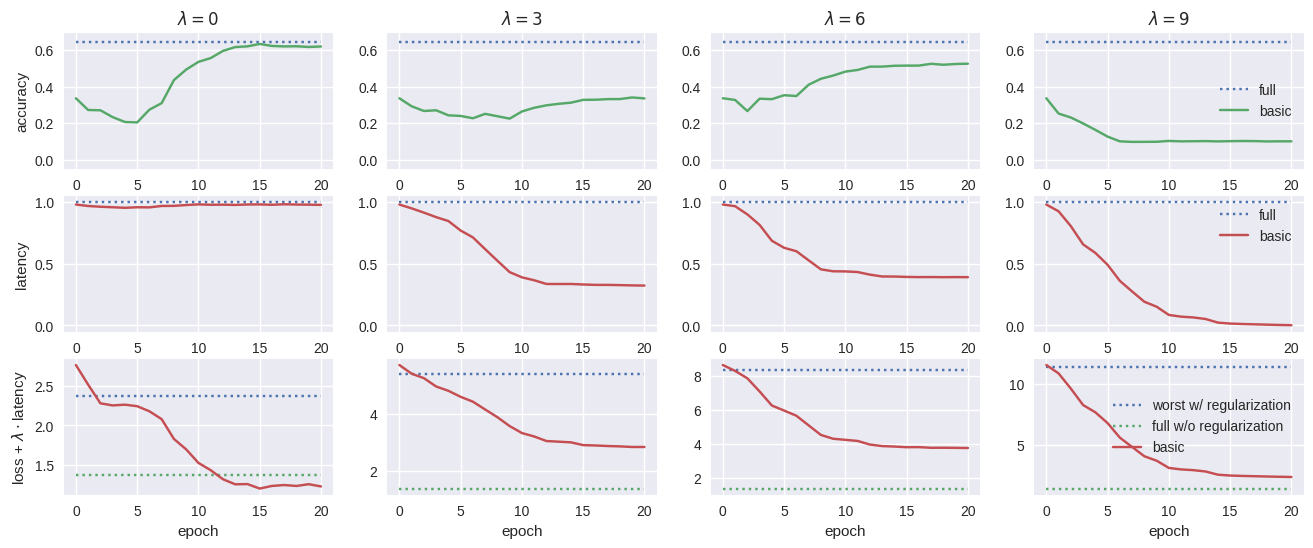

In [67]:
w = 4
plt.figure(figsize=(w*4, 6))

for i, (lambd, report) in enumerate(relaxed_report.items(), 1):
# for i, (lambd, report) in enumerate(discrete_report.items(), 1):
    plt.subplot(3, w, i)
    
    plt.title(rf"$\lambda={lambd}$")
    
    plt.plot([base_acc]*(EPOCHS+1), label='full', ls=':')
    plt.plot(report['acc'], label='basic')

    if i == 1:
      plt.ylabel('accuracy')
    if i == 4:
      plt.legend()
    plt.ylim(-0.05, base_acc + 0.05)
    
    
    plt.subplot(3, w, i + w)

    plt.plot([1]*(EPOCHS+1), label='full', ls=':')
    plt.plot(report['lat'], label='basic', color='C2')
    
    if i == 1:
      plt.ylabel('latency')
    if i == 4:
      plt.legend()
    plt.xlabel('epoch')
    plt.ylim(-0.05, 1.05)
    
    
    plt.subplot(3, w, i + 2*w)

    loss_history = [loss + lambd*lat for loss, lat in zip(report['loss'], report['lat'])]
    plt.plot([worst_loss + lambd]*(EPOCHS+1), label='worst w/ regularization', ls=':')
    plt.plot([base_loss]*(EPOCHS+1), label='full w/o regularization', ls=':')
    plt.plot(loss_history, label='basic')
    
    if i == 1:
      plt.ylabel('loss + $\lambda\cdot$latency')
    if i == 4:
      plt.legend()
    plt.xlabel('epoch')

plt.savefig(f'{figures}/convergence_rel.pdf', bbox_inches='tight')

In [68]:
history = [[loss + lambd*lat for loss, lat in zip(report['loss'], report['lat'])] for lambd, report in relaxed_report.items()]
history = [[round(l, 3) for l in h] for h in history]
print(*history, sep='\n')

[2.763, 2.515, 2.279, 2.253, 2.262, 2.243, 2.178, 2.079, 1.829, 1.697, 1.526, 1.434, 1.32, 1.256, 1.258, 1.202, 1.235, 1.246, 1.235, 1.257, 1.229]
[5.701, 5.396, 5.24, 4.947, 4.797, 4.585, 4.415, 4.141, 3.87, 3.559, 3.315, 3.195, 3.035, 3.012, 2.989, 2.891, 2.879, 2.86, 2.848, 2.826, 2.826]
[8.638, 8.292, 7.855, 7.081, 6.254, 5.957, 5.652, 5.087, 4.523, 4.299, 4.234, 4.169, 3.958, 3.868, 3.839, 3.802, 3.806, 3.767, 3.77, 3.763, 3.754]
[11.575, 10.881, 9.627, 8.268, 7.669, 6.775, 5.574, 4.805, 4.035, 3.671, 3.071, 2.949, 2.889, 2.777, 2.513, 2.443, 2.411, 2.387, 2.364, 2.342, 2.323]


[-0.248, -0.236, -0.026, 0.009, -0.019, -0.065, -0.099, -0.25, -0.132, -0.171, -0.092, -0.114, -0.064, 0.002, -0.056, 0.033, 0.011, -0.011, 0.022, -0.028]
[-0.305, -0.156, -0.293, -0.15, -0.212, -0.17, -0.274, -0.271, -0.311, -0.244, -0.12, -0.16, -0.023, -0.023, -0.098, -0.012, -0.019, -0.012, -0.022, 0.0]
[-0.346, -0.437, -0.774, -0.827, -0.297, -0.305, -0.565, -0.564, -0.224, -0.065, -0.065, -0.211, -0.09, -0.029, -0.037, 0.004, -0.039, 0.003, -0.007, -0.009]
[-0.694, -1.254, -1.359, -0.599, -0.894, -1.201, -0.769, -0.77, -0.364, -0.6, -0.122, -0.06, -0.112, -0.264, -0.07, -0.032, -0.024, -0.023, -0.022, -0.019]


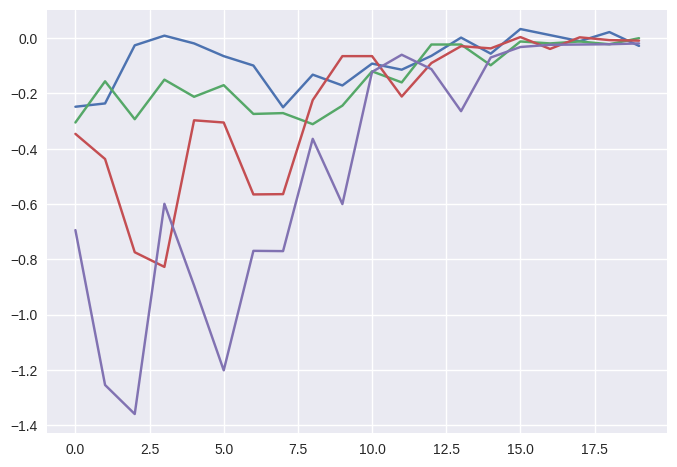

In [69]:
diff = [[round(h[i] - h[i-1], 3) for i in range(1, len(h))] for h in history]
print(*diff, sep='\n')
for h in diff:
  plt.plot(h)

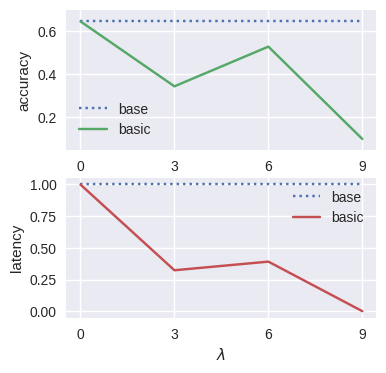

In [70]:
accs = [r['acc'][-1] for l, r in discrete_report.items()]
lats = [r['lat'][-1] for l, r in discrete_report.items()]

# accs = [r['acc'][-1] for l, r in relaxed_report.items()]
# lats = [r['lat'][-1] for l, r in relaxed_report.items()]

plt.figure(figsize=(4,4))

plt.subplot(2, 1, 1)
plt.plot(lambds, [base_acc] * len(accs), label='base', ls=':')
plt.plot(lambds, accs, label='basic')
plt.xticks(lambds)
plt.ylim(0.05, 0.7)

plt.ylabel('accuracy')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(lambds, [1] * len(lats), label='base', ls=':')
plt.plot(lambds, lats, label='basic', color='C2')

plt.ylim(-0.05, 1.05)

plt.ylabel('latency')
plt.xlabel('$\lambda$')
plt.xticks(lambds)

plt.legend()

plt.savefig(f'{figures}/acc&lat_vs_lambda.pdf', bbox_inches='tight')

In [71]:
import pickle

In [72]:
try:
  with open(f'{prefix}/cache.pkl', 'rb') as f:
    cache = pickle.load(f)
  print('loaded cache')
except:
  cache = {}

loaded cache


In [73]:
def get_greedy_report(backbone, **validate_kwargs):
    gammas = str(backbone.gammas)
    if gammas in cache:
        return cache[gammas]
    
    acc, loss, lat = validate(backbone, **validate_kwargs)
    cache[gammas] = (acc, loss, lat)

    with open(f'{prefix}/cache.pkl', 'wb') as f:
      pickle.dump(cache, f)

    return acc, loss, lat


def greedy_epoch(greedy_gammas, backbone, **validate_kwargs):
    reports = {
      'acc': [],
      'loss': [],
      'lat': [],
      'gammas': [],
    }

    for i in range(greedy_gammas.numel()):
        if greedy_gammas[i].item() == 1.0:
            backbone.gammas = greedy_gammas - one_hot(i, greedy_gammas.numel()).to(validate_kwargs['device'])
            acc, loss, lat = get_greedy_report(backbone, **valid_params)
      
            reports['acc'].append(acc)
            reports['loss'].append(loss + lambd*lat)
            reports['lat'].append(lat)
            reports['gammas'].append(backbone.gammas.clone().detach())

    best = np.argmin(reports['loss'])
    return reports['gammas'][best], reports['acc'][best], reports['loss'][best], reports['lat'][best]

In [74]:
backbone.make_gammas_discrete()

greedy_accs = {}
greedy_loss = {}
greedy_lats = {}

lambd_grid = list(range(10))

for lambd in tqdm_notebook(lambd_grid, total=10):
  greedy_gammas = torch.tensor([1.] * 60).to(device)

  greedy_accs[lambd] = [base_acc]
  greedy_loss[lambd] = [base_loss + lambd]
  greedy_lats[lambd] = [1]

  for _ in tqdm_notebook(range(60)):
    if greedy_accs[lambd][-1] < .15:
      continue

    greedy_gammas, acc, loss, lat = greedy_epoch(greedy_gammas, backbone, **valid_params)
    
    greedy_accs[lambd].append(acc)
    greedy_loss[lambd].append(loss)
    greedy_lats[lambd].append(lat)

backbone.make_gammas_relaxed()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

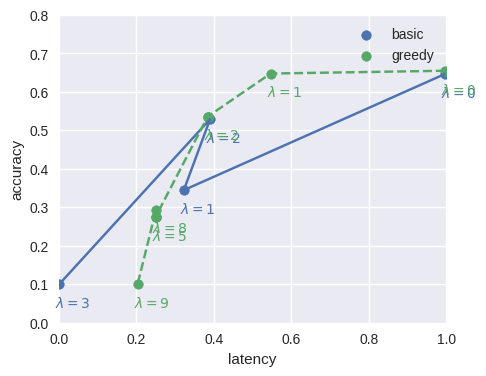

In [75]:
gaccs = [greedy_accs[l][np.argmin(greedy_loss[l])] for l in lambd_grid]
glats = [greedy_lats[l][np.argmin(greedy_loss[l])] for l in lambd_grid]

plt.figure(figsize=(5,4))

plt.scatter(lats, accs, label='basic')
plt.plot(lats, accs)

plt.scatter(glats, gaccs, label='greedy')
plt.plot(glats, gaccs, ls='--')

for i, (lat, acc) in enumerate(zip(lats, accs)):
    plt.text(lat-0.01, acc-0.06, rf'$\lambda={i}$', color='C0')

for i, (lat, acc) in enumerate(zip(glats, gaccs)):
    if i in {3,4, 6,7}:
        continue
    plt.text(lat-0.01, acc-0.06, rf'$\lambda={i}$', color='C1')

plt.xlabel('latency')
plt.ylabel('accuracy')

plt.xlim((0,1))
plt.ylim((0,0.8))

plt.legend()

plt.savefig(f'{figures}/acc_vs_lat.pdf', bbox_inches='tight')

In [76]:
!{sys.executable} -m pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from torcheval.metrics.aggregation.auc import AUC

metric = AUC()

metric.update(torch.tensor(lats), torch.tensor(accs))
print('basic:', metric.compute().item())
metric.reset()

metric.update(torch.tensor(glats), torch.tensor(gaccs))
print('greedy:', metric.compute().item())
metric.reset();

basic: 0.45653197169303894
greedy: 0.4528871774673462


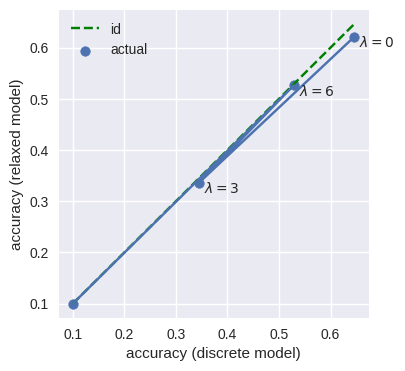

In [78]:
plt.figure(figsize=(4,4))

accs_dis = [r['acc'][-1] for l, r in discrete_report.items()]
accs_rel = [r['acc'][-1] for l, r in relaxed_report.items()]

plt.plot([0.1, base_acc], [0.1, base_acc], ls='--', color='green', label='id')
plt.scatter(accs_dis, accs_rel, label='actual')
plt.plot(accs_dis, accs_rel)

for i, (d, r) in enumerate(zip(accs_dis, accs_rel)):
    if i == 3:
        break
    plt.text(d+0.01, r-0.02, rf'$\lambda={lambds[i]}$')

plt.xlabel('accuracy (discrete model)')
plt.ylabel('accuracy (relaxed model)')

plt.legend()

plt.savefig(f'{figures}/acc_vs_acc.pdf', bbox_inches='tight')